# FlyGenius Flight Time Modeling v.2

FlyGenius is undergoing a major update from the first version. We're going to be using the same dataset, but redesign the prediction process. In the previous version, we used a `Sequential` model from Tensorflow to output one value. This time we are going to swap regression for classification, and predict the timeslot that each flight will depart in. 

## Importing and Cleaning the Data

In [1]:
import glob
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from math import isclose

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

The dataset is unchanged from before, so it is imported the same way.

In [2]:
january_data = glob.glob('data/flight-data/*/*_1.csv')

loaded_data = []

for path in january_data:
    this_data = pd.read_csv(path, skipinitialspace=True, low_memory=False)
    loaded_data.append(this_data)

df = pd.concat(loaded_data)

Once again, we import the lookup table for airlines

In [3]:
this_data = pd.read_csv('data/assorted/carriers.csv', skipinitialspace=True, low_memory=False)

airlines_lookup = this_data.set_index('Code')['Description'].to_dict()

### Cleaning

Now we remove all but the needed values from the dataframe. 

In [4]:
df = df[['Month', 'DayOfWeek', 'Reporting_Airline', 'Origin',
         'Dest', 'DepDelay', 'CRSElapsedTime', 'CRSDepTime', 'DepTimeBlk', 'ArrTimeBlk']]

Dropping any rows with missing values:

In [5]:
before = len(df.index)
df.dropna(inplace = True)
after = len(df.index)

diff = before - after

print("Removed {} entries out of {}".format(diff, before))

Removed 48998 entries out of 1935930


Note that we're using airline and airport IDs, which are alphanumeric. Before feeding these into the model, they must be encoded into integers.  

In [6]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Origin'])
zipped = zip(df['Origin'], integer_encoded)
airports = dict(zipped)

df['Origin'] = df['Origin'].replace(to_replace=airports, value=None)
df['Dest'] = df['Dest'].replace(to_replace=airports, value=None)

integer_encoded = label_encoder.fit_transform(df['Reporting_Airline'])
zipped = zip(df['Reporting_Airline'], integer_encoded)
airlines = dict(zipped)

df['Reporting_Airline'] = df['Reporting_Airline'].replace(to_replace=airlines, value=None)


integer_encoded = label_encoder.fit_transform(df['DepTimeBlk'])
zipped = zip(df['DepTimeBlk'], integer_encoded)
departures = dict(zipped)

df['DepTimeBlk'] = df['DepTimeBlk'].replace(to_replace=departures, value=None)


integer_encoded = label_encoder.fit_transform(df['ArrTimeBlk'])
zipped = zip(df['ArrTimeBlk'], integer_encoded)
arrivals = dict(zipped)

df['ArrTimeBlk'] = df['ArrTimeBlk'].replace(to_replace=arrivals, value=None)


# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(df['CRSDepTime'])
# zipped = zip(df['CRSDepTime'], integer_encoded)
# dep_times = dict(zipped)

# df['CRSDepTime'] = df['CRSDepTime'].replace(to_replace=dep_times, value=None)

In [7]:
y = df['DepDelay']
X = df.drop(columns=['DepDelay', 'CRSElapsedTime', 'CRSDepTime', 'Month', 'Dest'])

y = y.tolist()

X.head()

,DayOfWeek,Reporting_Airline,Origin,DepTimeBlk,ArrTimeBlk
0,3,1,89,6,9
1,4,1,89,6,9
2,5,1,89,6,9
3,6,1,89,6,9
4,7,1,89,6,9


Now, we need to convert each of the times in `y` into a category label. The categories are:

 0. (x < 0)
 1. (0 <= x < 5) 
 2. (5 <= x < 10)
 3. (10 <= x < 20)
 4. (x > 20) 

In [8]:

    
for i in range(len(y)):
    if y[i] < 5:
        y[i] = 0
#     elif y[i] >= 0 and y[i] < 5:
#         y[i] = 1
#     elif y[i] >= 5 and y[i] < 10:
#         y[i] = 2
#     elif y[i] >= 10 and y[i] < 20:
#         y[i] = 3
    else:
        y[i] = 1


## Building the Model

Now we can begin to build the model. As before, we're using Tensorflow so we can export the models as `json` files and open them up with tensorflow.js.

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train[:5])

        DayOfWeek  Reporting_Airline  Origin  DepTimeBlk  ArrTimeBlk
64157           6                 10     116          15          17
102817          3                  4      18          11          13
17529           1                 13     154          13          15
188324          6                 13     178          18           0
200352          3                 16     304          11          12


Now, the model. Previously we were using a regression model, but with a bit of tweaking we can make a classification model using the same keras `Sequential` model. Rather than one value output, the new model uses a softmax layer to output two possible values for the two classes.

In [11]:
def build_regression_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

  return model


def build_classification_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

EPOCHS = 1

In [12]:
model = build_classification_model()

model.fit(X_train, y_train, epochs=EPOCHS)

Instructions for updating:
Colocations handled automatically by placer.
1509545/1509545 [==============================] - 67s 44us/sample - loss: 0.5849 - acc: 0.7151


Now that the model is trained, we can check the accuracy on the test set. 

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)

test_acc

377387/377387 [==============================] - 7s 19us/sample - loss: 0.5791 - acc: 0.7162


0.71623296

Clearly the accuracy is not great, but there's more that can be done. Let's take a look at some of the predictions.

In [14]:
predictions = model.predict(X_test)

for index in range(10):
    print('Predicted class: {}'.format(np.argmax(predictions[index])))
    print('Real class: {}'.format(y_test[index]))

    print('{:2.0f}% chance correct\n'.format(100*np.max(predictions[index])))

Predicted class: 0
Real class: 0
79% chance correct

Predicted class: 0
Real class: 1
72% chance correct

Predicted class: 0
Real class: 0
85% chance correct

Predicted class: 0
Real class: 0
61% chance correct

Predicted class: 0
Real class: 0
68% chance correct

Predicted class: 0
Real class: 0
74% chance correct

Predicted class: 0
Real class: 1
64% chance correct

Predicted class: 0
Real class: 1
65% chance correct

Predicted class: 0
Real class: 0
79% chance correct

Predicted class: 0
Real class: 1
62% chance correct



As might be expected, it looks like when the model produces the wrong classification, the percent chance that it is correct is lower relative to when it produces the correct classification. Let's gather these predicted scores. 

In [15]:
wrong_guesses = []
correct_guesses = []

for index in range(len(predictions)):
    if np.argmax(predictions[index]) != y_test[index]:
        wrong_guesses.append(np.max(predictions[index]))
    else:
        correct_guesses.append(np.max(predictions[index]))

print('Wrong guesses: avg {:2.0f}%, varience {:.3f}%'.format(100*np.mean(wrong_guesses), 100*np.var(wrong_guesses)))
print('Right guesses: avg {:2.0f}%, varience {:.3f}%'.format(100*np.mean(correct_guesses), 100*np.var(correct_guesses)))

Wrong guesses: avg 70%, varience 0.463%
Right guesses: avg 73%, varience 0.601%


Let's take a look at the distribution of correct and incorrect guesses and their related probabilities. 

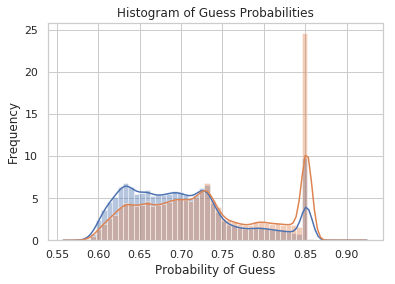

In [47]:
sns.distplot(wrong_guesses)
sns.distplot(correct_guesses)
plt.title('Histogram of Guess Probabilities')
plt.xlabel('Probability of Guess')
plt.ylabel('Frequency')
plt.show()

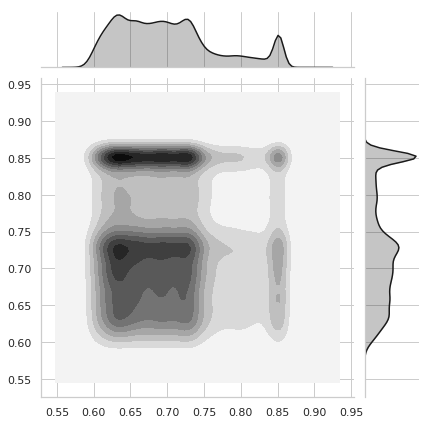

In [51]:
new_correct = np.split(correct_guesses, [len(wrong_guesses)])[0]

sns.jointplot(x=wrong_guesses, y=new_correct, kind="kde", color="k")

plt.show()

This graph compares the frequency of the probabilities when guessing correctly (on the Y axis) and incorrectly (X axis). We can see an interesting bimodal relationship here. The model more often assigns a probability of around 0.85 to guesses that are made correctly and less often assigns the same probability to incorrect guesses, which is good. In other words, when it assigns a very high probability, it is much more often right. However, most of the guesses (both incorrect and correct) seem to be in the range from 0.6-0.75, skewed right, with a low frequency of guesses in the range 0.75-0.8. This indicates that the model is mostly producing guesses with relatively average probabilities of being correct. 

This indicates that there is more work to be done to the model, such that the probabilities move upwards towards the second mode around 0.85 and away from the mode around 0.7. 

Let's take a look at what happens when the probability cutoff required for identification of a given class moves upwards from 0.5. 